In [916]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc

In [917]:
R = 100 #Ohm
L = 10*1e-9 #H
f = 1e9 #GHz
W = 2*math.pi*f
ZL = R + 2*math.pi*f*L*1J
print("ZL = {}".format(ZL))
Zo = 50
Yo = 1/Zo
#Asumiendo vacío
lambda_z = 3*1e8/f
print(lambda_z)

ZL = (100+62.83185307179586j)
0.3


In [918]:
x = np.linspace(900*1e3,1e9, 10000)

## Diseño Red L

Dado que R > Zo, se aplican las siguientes fórmulas para buscar las susceptancias y reactancias:
$B = \frac{X_L \pm \sqrt{\frac{R_L}{Z_o}}\cdot \sqrt{R_L^2 + X_L^2Z_oR_L}}{R_L^2 + X_L^2}$
$X = \frac{1}{B} + \frac{X_LZ_o}{R_L} + \frac{Z_o}{BR_L}$

In [919]:
B_1 = lambda RL, XL: [(XL+(np.sqrt(RL/Zo)*np.sqrt(RL**2 + XL**2 - (Zo*RL))))/(RL**2 + XL**2), (XL-(np.sqrt(RL/Zo)*np.sqrt(RL**2 + XL**2 - (Zo*RL))))/(RL**2 + XL**2)]
X_1 = lambda RL, XL, B: [(1/B[0]) + ((XL*Zo)/RL) - (Zo/(RL*B[0])), (1/B[1]) + ((XL*Zo)/RL) - (Zo/(RL*B[1]))]
B = B_1(ZL.real, ZL.imag)
X = X_1(ZL.real, ZL.imag, B_1(ZL.real, ZL.imag))
print("solución 1: B = {}, X = {}".format(B[0], X[0]))
print("solución 2: B = {}, X = {}".format(B[1], X[1]))

solución 1: B = 0.01409584404804315, X = 66.887374595045
solución 2: B = -0.005086299180675378, X = -66.88737459504497


In [920]:
rta_redesL = []
for B_ in B:
    if (B_ > 0):
        rta_redesL.append( [B_, "Capacitor Paralelo", B_/W] )
    else:
        rta_redesL.append( [B_,  "Inductor Paralelo", -1/(B_*W)] )
for X_ in X:
    if (X_ > 0):
        rta_redesL.append( [X_, "Inductor Serie", X_/W] )
    else:
        rta_redesL.append( [X_,  "Capacitor Serie", -1/(X_*W)] )
Cp, Cs, Lp, Ls = 0, 0, 0, 0
print("Solución 1:")
if(rta_redesL[0][1] == "Capacitor Paralelo"):
    print(rta_redesL[0][1] + " Cp = {}pF".format(round(rta_redesL[0][2]*1e12, 3)))
    Cp = rta_redesL[0][2]
else:
    print(rta_redesL[0][1] + " Lp = {}nH".format(round(rta_redesL[0][2]*1e9, 3)))
    Lp = rta_redesL[0][2]
if(rta_redesL[2][1] == "Capacitor Serie"):
    print(rta_redesL[2][1] + " Cs = {}pF".format(round(rta_redesL[2][2]*1e12, 3)))
    Cs = rta_redesL[2][2]
else:
    print(rta_redesL[2][1] + " Ls = {}nH".format(round(rta_redesL[2][2]*1e9, 3)))
    Ls = rta_redesL[2][2]
print("Solución 2:")
if(rta_redesL[1][1] == "Capacitor Paralelo"):
    print(rta_redesL[1][1] + " Cp = {}pF".format(round(rta_redesL[1][2]*1e12, 3)))
    Cp = rta_redesL[1][2]
else:
    print(rta_redesL[1][1] + " Lp = {}nH".format(round(rta_redesL[1][2]*1e9, 3)))
    Lp = rta_redesL[1][2]
if(rta_redesL[3][1] == "Capacitor Serie"):
    print(rta_redesL[3][1] + " Cs = {}pF".format(round(rta_redesL[3][2]*1e12, 3)))
    Cs = rta_redesL[3][2]
else:
    print(rta_redesL[3][1] + " Ls = {}nH".format(round(rta_redesL[3][2]*1e9, 3)))
    Ls = rta_redesL[3][2]

Solución 1:
Capacitor Paralelo Cp = 2.243pF
Inductor Serie Ls = 10.645nH
Solución 2:
Inductor Paralelo Lp = 31.291nH
Capacitor Serie Cs = 2.379pF


Para el cálculo de la ROE se tiene lo siguiente:
\begin{align*}
&\text{Opción 1:}&
&\text{Opción 2:}\\
&Z_{in} = 10.65\text{nH}\cdot \omega j + \left ( Z_L\;//\;\frac{-j}{2.24\text{pF}\cdot\omega} \right )&
&Z_{in} = \frac{-j}{2.4\text{pF}\cdot\omega} + \left ( Z_L\;//\;31,3\text{nH}\cdot \omega j  \right )\\
\end{align*}

In [921]:
RedL_Zin_1 = lambda Zl, f: Ls*2*math.pi*f*1J + ((1/Zl) + (-1J/(Cp*2*math.pi*f))**-1)**-1
RedL_Zin_2 = lambda Zl, f: (-1J/(Cs*2*math.pi*f)) + ((1/Zl) + (Lp*2*math.pi*f*1J)**-1)**-1
#Chequeo que de ~50 Ohms a 1GHz
ZL_RedL_1 = lambda f: RedL_Zin_1(R + 1J*2*math.pi*f*L,f)
ZL_RedL_2 = lambda f: RedL_Zin_2(R + 1J*2*math.pi*f*L,f)

## Diseño Stub Simple

Para el cálculo del Stub se aplican las siguiente fórmulas:
\begin{equation*}
    t = \left\{\begin{matrix}
\left ( X_L\pm \sqrt{\frac{R_L[(Z_o - R_L)^2+X_L^2]}{Z_o}} \right )\frac{1}{R_L-Z_o}\;\;\;\; R_L\neq Z_o\\
-\frac{X_L}{2Z_o}\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; R_L= Z_o
\end{matrix}\right.
\end{equation*}
La distancia entre la carga y el stub se calcula como:
\begin{equation*}
d = \left\{\begin{matrix}
\frac{\lambda}{2\pi}\cdot arctg(t)\;\;\;\;\;\;\;\;\; t \geq 0\\\\
\frac{\lambda}{2\pi}[\pi + arctg(t)]\;\;\; t < 0
\end{matrix}\right.
\end{equation*}

In [922]:
t_stub_par = lambda RL, XL: [(XL+np.sqrt(RL*((Zo-RL)**2 + XL**2)/Zo))/(RL-Zo) , (XL-np.sqrt(RL*((Zo-RL)**2 + XL**2)/Zo))/(RL-Zo) ]
d_stub_par = lambda t: np.arctan(t)/(2*math.pi) if (t >= 0) else (1/(2*math.pi))*(math.pi+np.arctan(t))
t_stub_simple = t_stub_par(ZL.real, ZL.imag)
print("Valores de t = {}".format([t_stub_simple[0],t_stub_simple[1]]))
print("Distancias (en función de lambda):")
d_stub_simple = [d_stub_par(t_stub_simple[0]), d_stub_par(t_stub_simple[1])]
print("d1 = {} λ, d2 = {} λ".format(round(d_stub_simple[0],3), round(d_stub_simple[1],3)))

Valores de t = [3.5278203231628513, -1.0145462002910168]
Distancias (en función de lambda):
d1 = 0.206 λ, d2 = 0.374 λ


La longitud de las lineas puede calcularse de la siguiente forma:
\begin{align*}
l = \left\{\begin{matrix}
\frac{\lambda}{2\pi}\cdot arctan\left ( \frac{Y_o}{B} \right ) \;\;\;\;\;\; \text{Stub en CC}
\\ \\
-\frac{\lambda}{2\pi}\cdot arctan\left ( \frac{B}{Y_o} \right ) \;\;\; \text{Stub en CA}
\end{matrix}\right.
\end{align*}
Siendo $B = \frac{R_L^2t-(Z_o-X_Lt)(X_L+Z_ot)}{Z_o\;[R_L^2+(X_L+Z_ot)^2]}$

In [923]:
B_stub_par = lambda RL, XL, t: (((RL**2)*t) - ((Zo-(XL*t))*(XL+(Zo*t)))) / (Zo*((RL**2) + (XL+(Zo*t))**2))
l_stub_par = lambda B, CC: (np.arctan(1/(B*Zo))/(2*np.pi)) if(CC) else -np.arctan(B*Zo)/(2*np.pi)
l_stub_par_correc = lambda l: l + 0.5 if(l<0) else l

Para la opción 1:

In [924]:
B_stub_simple = [B_stub_par(ZL.real, ZL.imag, t_stub_simple[0]), B_stub_par(ZL.real, ZL.imag, t_stub_simple[1])]
ls_stub_simple = [l_stub_par_correc(l_stub_par(B_stub_simple[0], True)), l_stub_par_correc(l_stub_par(B_stub_simple[0], False))]#CC y CA
print("Para opción 1 (d1 = {}λ), se tiene B = {}, lCC = {} λ, lCA = {} λ".format(round(d_stub_simple[0],3),round(B[0],3), round(ls_stub_simple[0],3), round(ls_stub_simple[1],3)))

Para opción 1 (d1 = 0.206λ), se tiene B = 0.014, lCC = 0.115 λ, lCA = 0.365 λ


Para la opción 2:

In [925]:
ls_stub_simple = [l_stub_par_correc(l_stub_par(B_stub_simple[1], True)), l_stub_par_correc(l_stub_par(B_stub_simple[1], False))]#CC y CA
print("Para opción 2 (d2 = {}λ), se tiene B = {}, lCC = {} λ, lCA = {} λ".format(round(d_stub_simple[1],3),round(B[1],3), round(ls_stub_simple[0],3), round(ls_stub_simple[1],3)))

Para opción 2 (d2 = 0.374λ), se tiene B = -0.005, lCC = 0.385 λ, lCA = 0.135 λ


In [926]:
ls_stub_simple = [l_stub_par_correc(l_stub_par(B_stub_simple[0], True)), l_stub_par_correc(l_stub_par(B_stub_simple[0], False))]#CC y CA
lambda_z_stub_simple = 3*1e8 / (1e9)
beta_simple = lambda f_: 2*np.pi*f_ / (3*1e8)
d_stub_simple = lambda_z_stub_simple * d_stub_simple[0]
l_stub_simple = lambda_z_stub_simple * ls_stub_simple[1]
print("d_stub = {} m".format(round(d_stub_simple,5)))
print("l_stub = {} m".format(round(l_stub_simple,5)))

d_stub = 0.06181 m
l_stub = 0.10947 m


La impendancia de entrada a la derecha de la linea de transmisión de longitud $d$ se calcula como:
\begin{align*}
Z_{in} = Z_o \cdot \frac{Z_L + Z_o\cdot tan(\beta d)j}{Z_o + Z_L \cdot tan(\beta d)j}
\end{align*}
La impendancia que representa el stub (en CA) es:
\begin{align*}
Z_{in-stub} = -j\cdot Z_o\; cotan(\beta l)
\end{align*}
Finalmente la impedancia de entrada total es:
\begin{align*}
Z_{in} = \frac{1}{Y_{in-STUB}+Y_{in-LT}}
\end{align*}

In [927]:
Yin_1 = lambda f_, ZL: 1/ (Zo*(ZL + Zo*np.tan(beta_simple(f_)*d_stub_simple)*1J) / (Zo + ZL*np.tan(beta_simple(f_)*d_stub_simple)*1J))
Yin_stub_CA = lambda f_: 1 / (-1J*Zo/np.tan(beta_simple(f_)*l_stub_simple))
Yin_stub = lambda f_: (Yin_1(f_, R + 2*np.pi*L*f_*1J) + Yin_stub_CA(f_))
ZL_stub_simple = lambda f_: 1/Yin_stub(f_)
print(ZL_stub_simple(1e9))

(50.000000000000014-5.2041704279304244e-14j)


## Stub Doble

Fijando un $d = \frac{3}{8}\;\lambda $, se calcula se si puede adaptar o no la carga. Para eso se debe cumplir:
\begin{align*}
0 \leq G_L \leq \frac{1}{Z_o\;sen(\beta d)}
\end{align*}
Donde:
\begin{align*}
&Z_{L} = \frac{1}{G_{L}+B_{L}j}&
&t = tan(\beta d)\\
&B_1=-B_L+\frac{Y_o\pm \sqrt{(1+t^2)G_LY_o-G_L^2t^2}}{t}&
&B_2 = \frac{\pm Y_o\sqrt{(1+t^2)G_LY_o-G_L^2t^2}+G_LY_o}{G_Lt}\\
\end{align*}


In [928]:
d_stub_doble = 3/8
t_stub_doble = np.tan(2*math.pi*d_stub_doble)
GL = ((1/ZL).real)
BL = ((1/ZL).imag)
B1_stub_doble = lambda GL, BL, beta, d: [-BL + (Yo + np.sqrt((1+(np.tan(beta*d))**2)*GL*Yo - (GL*np.tan(beta*d))**2))/np.tan(beta*d), -BL + (Yo - np.sqrt((1+np.tan(beta*d)**2)*GL*Yo - (GL*np.tan(beta*d))**2))/np.tan(beta*d)]
B2_stub_doble = lambda GL, BL, beta, d:[ (Yo*np.sqrt((1+(np.tan(beta*d))**2)*GL*Yo-(GL*np.tan(beta*d))**2) + GL*Yo) / (GL*np.tan(beta*d)),(-Yo*np.sqrt((1+np.tan(beta*d)**2)*GL*Yo-(GL*np.tan(beta*d))**2) + GL*Yo) / (GL*np.tan(beta*d))]
if(GL <= (1/(Zo*np.sin(2*math.pi*d_stub_doble)))):
    print("Se puede adaptar la carga ZL = {}".format(ZL))
    print("GL = {}, BL = {}".format(round(GL,6), round(BL,6)))
    B1, B2 = B1_stub_doble(GL, BL, 2*math.pi, d_stub_doble), B2_stub_doble(GL, BL, 2*math.pi, d_stub_doble)
    print("B1 = {}, {}, B2 = {}, {}".format(round(B1[0],6),round(B1[1],6),round(B2[0],6), round(B2[1],6)))
    l1 = [l_stub_par_correc(l_stub_par(B1[0],False)),l_stub_par_correc(l_stub_par(B1[1], False)), l_stub_par_correc(l_stub_par(B1[0],True)),l_stub_par_correc(l_stub_par(B1[1], True))]
    l2 = [l_stub_par_correc(l_stub_par(B2[0],False)),l_stub_par_correc(l_stub_par(B2[1], False)), l_stub_par_correc(l_stub_par(B2[0],True)),l_stub_par_correc(l_stub_par(B2[1], True))]
    print("l1_1_CA = {}λ, l1_2_CA = {}λ, l1_1_CC = {}λ, l1_1_CC = {}λ".format(round(l1[0],3),round(l1[1],3),round(l1[2],3), round(l1[3],3)))
    print("l2_1_CA = {}λ, l2_2_CA = {}λ, l2_1_CC = {}λ, l2_1_CC = {}λ".format(round(l2[0],3),round(l2[1],3),round(l2[2],3), round(l2[3],3)))


Se puede adaptar la carga ZL = (100+62.83185307179586j)
GL = 0.00717, BL = -0.004505
B1 = -0.030837, -0.000153, B2 = -0.062798, 0.022798
l1_1_CA = 0.158λ, l1_2_CA = 0.001λ, l1_1_CC = 0.408λ, l1_1_CC = 0.251λ
l2_1_CA = 0.201λ, l2_2_CA = 0.365λ, l2_1_CC = 0.451λ, l2_1_CC = 0.115λ


In [929]:
err_stub_doble = 1
lambda_stubdoble = 3*1e8 / f
l1_stubdoble = l1[1] * lambda_stubdoble
l2_stubdoble = l2[1] * lambda_stubdoble
d_stub_doble = d_stub_doble * lambda_stubdoble
beta_stubdoble = lambda f_ : (2*np.pi) / (3*1e8 / f_)
print("l1_CA = {} m".format(round(l1_stubdoble,6)))
print("d_stub_doble = {} m".format(round(d_stub_doble,4)))
print("l2_CA = {} m".format(round(l2_stubdoble,4)))

l1_CA = 0.000366 m
d_stub_doble = 0.1125 m
l2_CA = 0.1094 m


La impendancia vista por stubs en CA:
\begin{align*}
Z_{in-stub} = -j\cdot Z_o\; cotan(\beta l)
\end{align*}
La admitancia que se ve a la derecha de la linea $l_{2}$:
\begin{align*}
&{Z_{in}}'  = Z_o \cdot \frac{{Z_L}' + Z_o\cdot tan(\beta d)j}{Z_o + {Z_L}' \cdot tan(\beta d)j}&
&{Y_L}' = Y_L + Y_{stub\;l_{1}}\\
\end{align*}
Finalmente la admitancia de entrada total resula:
\begin{align*}
Y_{in} = Y_{stub\;l_{2}} + {Y_{in}}'
\end{align*}

In [930]:
Zin1_stubdoble = lambda f_: ((1/(1j*Zo/np.tan(beta_stubdoble(f_)*l1_stubdoble))) + (1/(R + 1j*2*np.pi*L*f_)))**-1
Zin2_stubdoble = lambda f_, Z_L: Zo * (Z_L + Zo*np.tan(beta_stubdoble(f_)*d_stub_doble)*1J) / (Zo + 1j*Z_L*np.tan(beta_stubdoble(f_)*d_stub_doble))
Y_lCA = lambda f_: 1 / (1j*Zo/np.tan(beta_stubdoble(f_)*l2_stubdoble))
ZL_stub_doble = lambda f_ : ((1/Zin2_stubdoble(f_, Zin1_stubdoble(f_))) + Y_lCA(f_))**-1


## Transformador de $\frac{\lambda}{4}$

Dado que estamos trabajando con una carga compleja, primero se lleva la carga al eje real. Para se calcula la longitud $d$ de la linea que estará en serie con la carga:
\begin{align*}
t = \frac{(Z_o^2-R_L^2-X_L^2) \pm \sqrt{(Z_o^2-R_L^2-X_L^2)^2 + 4X_L^2Z_o^2}}{2X_L Z_o}
\end{align*}


In [931]:
t_transformador = lambda RL, XL: [((Zo**2 - RL**2 - XL**2) + np.sqrt((Zo**2 - RL**2 -XL**2)**2 + (2*XL*Zo)**2))/(2*XL*Zo), ((Zo**2 - RL**2 - XL**2) - np.sqrt((Zo**2 - RL**2 -XL**2)**2 + (2*XL*Zo)**2))/(2*XL*Zo)]
t_transf = t_transformador(ZL.real, ZL.imag)
print(t_transf)
d_transf = [d_stub_par(t_transf[0]), d_stub_par(t_transf[1])]
print("d1 = {}λ, d2 = {}λ " .format(round(d_stub_par(t_transf[0]),3), round(d_stub_par(t_transf[1]),3)))

[0.2563873425868896, -3.900348550401237]
d1 = 0.04λ, d2 = 0.29λ 


Se toma únicamente d1, ya que es la distancia más corta.

In [932]:
d_transf = d_transf[0]

La impendancia justo a la derecha del transformador es:
\begin{align*}
{Z}' = {R_L}' + {X_L}'j = Z_o \frac{Z_L + j\cdot Zo\;t}{Z_o + j\cdot Z_L\;t}}
\end{align*}

In [933]:
Zin_1_transf = lambda ZL_, t_: Zo * (ZL_ + (1J*Zo*t_)) / (Zo + (1J*ZL_*t_))
RL_prima = Zin_1_transf(ZL,t_transf[0])
print(RL_prima)

(147.53306352380125-1.706794192838452e-14j)


Ahora la impendancia de la segunda linea $Z_1$ resulta:
\begin{align}
Z_1 = \sqrt{Z_o\;{R_L}'}
\end{align}

In [934]:
Z1 = np.sqrt(Zo*RL_prima.real)
print("Z1 = {} Ω".format(round(Z1,3)))

Z1 = 85.887 Ω


In [935]:
eef_trans_d = 3.35669
lambda_z_transf_l1 = (3*1e8)/((1e9)*np.sqrt(eef_trans_d))
print(lambda_z_transf_l1)
l_trans_l1 = lambda_z_transf_l1 * d_transf
print(l_trans_l1)
eef_trans = 3.111
lambda_z_transf = (3*1e8)/((1e9)*np.sqrt(eef_trans))
print(lambda_z_transf)
l_trans = lambda_z_transf/4
print(l_trans)

0.16374409126177963
0.006540740764295713
0.17008705015002387
0.04252176253750597


Para el cálculo de la impendancia de entrada total se tien en cuenta lo siguiente:
\begin{align*}
&Z_{in1} = Z_o \frac{Z_L + j\cdot Z_o\;tan(\beta d)}{Z_o + j\cdot Z_L\;tan(\beta d)}&
&Z_{in2} = \left\{\begin{matrix}
Z_{1}\frac{Z_{in1}+j\cdot Z_{1}\;tan\left ( \beta l_{\frac{\lambda}{4}} \right )}{Z_{1}+j\cdot Z_{in1}\;tan\left ( \beta l_{\frac{\lambda}{4}} \right )} \;\;\;\; \text{si\;} \beta l_{\frac{\lambda}{4}} \neq \frac{\pi}{2} \text{\; es decir $f\neq1\;GHz$}\\
\\
\frac{Z_{1}^2}{Z_{in1}} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\text{si\;} \beta l_{\frac{\lambda}{4}} \neq \frac{\pi}{2} \text{\; es decir $f=1\;GHz$}
\end{matrix}\right.&
\end{align*}

In [936]:
beta_trans = lambda f_,er: (2*math.pi*f_) / ((3*1e8)/np.sqrt(er)) ##Esto es lo que hay que definir en base a si lo implemento con microcintas o que
Zin_transf = lambda Z0, Zc, beta, l: Z0*(Zc + (1J*Z0*np.tan(beta*l))) / (Z0 + (1J*Zc*np.tan(beta*l))) if (beta*l != (np.pi/2)).all() else Z0**2 /Zc
Zin_1 = Zin_transf(Zo, ZL, beta_trans(1e9, eef_trans_d), l_trans_l1)

Para barrido en frecuencia:


In [937]:
ZL_trans = lambda f: Zin_transf(Z1, Zin_transf(Zo, R + (1J*L*2*math.pi*f), 2*np.pi*f/(3*1e8/np.sqrt(eef_trans_d)), l_trans_l1), 2*np.pi*f/(3*1e8/np.sqrt(eef_trans)), l_trans)

Grafico $ROE$ y $RL$. Para eso defino $\Gamma$ y $ROE$, y $RL$:

In [938]:
Gamma = lambda Zl : (Zl-Zo) / (Zl+Zo)
ROE = lambda r: (1+abs(r)) / (1-abs(r))
RL = lambda r: -20*np.log(abs(r))

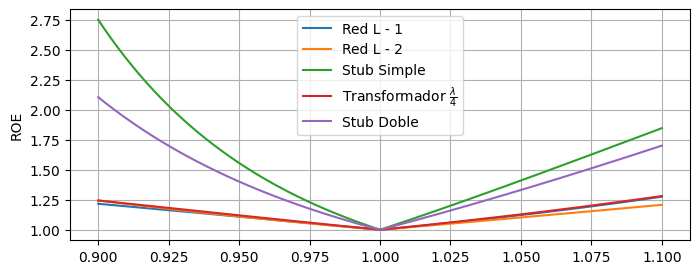

In [939]:
plt.figure(figsize=(8,3))
x = np.linspace(900, 1100, 10000) * sc.mega
plt.grid()
plt.plot(x*1e-9, ROE(Gamma(ZL_RedL_1(x))), label="Red L - 1")
plt.plot(x*1e-9, ROE(Gamma(ZL_RedL_2(x))), label="Red L - 2")
plt.plot(x*1e-9, ROE(Gamma(ZL_stub_simple(x))), label="Stub Simple")
plt.plot(x*1e-9, ROE(Gamma(ZL_trans(x))), label=r"Transformador $\frac{\lambda}{4}$")
plt.plot(x*1e-9, ROE(Gamma(ZL_stub_doble(x))), label = r"Stub Doble")
#plt.xlabel("f [GHz]")
plt.ylabel("ROE")
plt.legend()
plt.show()

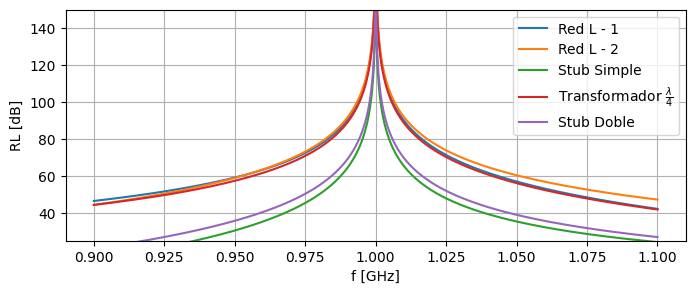

In [940]:
plt.figure(figsize=(8,3))
plt.grid()
plt.plot(x*1e-9, RL(Gamma(ZL_RedL_1(x))), label="Red L - 1")
plt.plot(x*1e-9, RL(Gamma(ZL_RedL_2(x))), label="Red L - 2")
plt.plot(x*1e-9, RL(Gamma(ZL_stub_simple(x))), label="Stub Simple")
plt.plot(x*1e-9, RL(Gamma(ZL_trans(x))), label=r"Transformador $\frac{\lambda}{4}$")
plt.plot(x*1e-9, RL(Gamma(ZL_stub_doble(x))), label = r"Stub Doble")
plt.xlabel("f [GHz]")
plt.ylabel("RL [dB]")
plt.ylim([25,150])
plt.legend()
plt.show()